<h1> Identifying Participants with Imaging Data 

This notebook provides an example of how to identify participants with a bulk imaging field and download these files to an instance. This notebook uses bash and python

Run info:
* runtime: ~20 minutes
* recommended instance: mem1_ssd1_v2_x8
* cost: ~£0.05 


To identify field ids of imaging measures you can use [UK Biobank's showcase](https://biobank.ndph.ox.ac.uk/showcase/).

Information relating to imaging can be found within [Category 100003](https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=100003) and the following sub-categories:

* [Catergory 105](https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=105)- Abdominal MRI
* [Category 100](https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=100)- Brain MRI
* [Category 102](https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=102)- Heart MRI
* [Category 103](https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=103)- DXA assessment

On the RAP imaging data can be found within the bulk folder. Each image type/sequence per paricipant is in a zip file  with naming convention *{eid}_{field_id}_{instance}_0.zip*. 
The following function gets all the file paths associated with an imaging field id and extracts key information: parameter, eid, field id and instance. This is outputed as a csv file.

**This section will use a bash kernel**

The Jupyter instance should open the notebook with a bash kernel 

In [ ]:
# Function: extract_eids
# Description:
# On the RAP imaging data can be found within the bulk folder within a dispensed project. 
# Each image type/sequence per paricipant is in a zip file  with naming convention *{eid}_{field_id}_{instance_0}.zip*. 
# This function checks the field id is a bulk imaging field and if it is searches and gathers all file paths for a specified field id and extracts specific parameters. 
# The results are written to an output file in csv format.
#
# Parameters:
#   $1 - output_file: The file where the results will be saved.
#   $@ - field_ids: An array of field IDs to search and process. These field_ids should be bulk imaging fields.
#
# Usage:
#   extract_eids "output.csv" 20204 20254

extract_eids(){
 local output_file="$1"
 shift
 local field_ids=("$@")

 # Print header to the output file if it doesn't exist
 if [ ! -f "$output_file" ]; then
   echo "filepath,param,eid,field_id,ins" > "$output_file"
 fi

 for field_id in "${field_ids[@]}"; do
   # Capture the first line of output with timeout for reading
   first_line=$( dx find data --property field_id="$field_id" 2>/dev/null | head -n 1)
    
   if [[ "$first_line" == *"Bulk"* ]]; then
     # 'Bulk' found in the filepath, process this field_id
     dx find data --property field_id="$field_id" 2>/dev/null | awk -F'/' '
     { # Find the index of "/Bulk/"
       start_index = index($0, "/Bulk/")
       # Find the index of ".zip"
       end_index = index($0, ".zip") + 4
       # Extract filepath starting from "/Bulk/" up to ".zip"
       filepath = substr($0, start_index, end_index - start_index)
       split($6, a, "_")
       param = $4
       eid = a[1]
       field_id = a[2]
       ins = a[3]
       print filepath "," param "," eid "," field_id "," ins
     }
     ' >> "$output_file"
   else
     # 'Bulk' not found in the filepath
     echo "Field ID $field_id is not a bulk field."
   fi
 done
}

In the following example, the function finds all filepaths for field ids 20204 and 20254

In [ ]:
extract_eids "imaging_eids.csv" 20204 20254


The output file can be downloaded to your project so it is available for future instances.

In [ ]:
dx upload "imaging_eids.csv"

The "imaging_eids.csv" file can be used to download the bulk imaging files of interest to your instance.


Create a list of file paths to download using the out of extract_eids

In [ ]:
 # Extract column containing file paths from "imaging_eids.csv" 
 # Remove heading 
 # For speed,in this example, also extracting the first 2 rows only
awk -F',' 'NR > 1 && NR <= 3 {print $1}' imaging_eids.csv > file_paths.txt


The following function uses dx download to download, to an instance, the filepaths in a provided txt file.

In [ ]:
# Function: download_imaging_files()
# Description:
#   This function automates the download of imaging files from a RAP project based
#   on paths specified in a txt file.
#
# Parameters:
#   $1 - A txt file containing file paths to bulk imaging files on the RAP
#
# Example Usage:
#  download_imaging_files file_paths.txt

download_imaging_files() {
  # Check if the file_paths.txt argument is provided and exists
  if [[ -z "$1" || ! -f "$1" ]]; then
    echo "Error: file_paths.txt is not provided."
    return 1
  fi

  # Get the project ID
  local PR
  PR=$(dx env | grep project- | cut -f 2)
  
  # Check if the project ID was successfully retrieved
  if [[ -z "$PR" ]]; then
    echo "Error: Could not retrieve project ID."
    return 1
  fi

  # Construct and execute the dx download commands for each line in the file_paths.txt
  local file_paths_file=$1
  while IFS= read -r file_path; do
    local command="dx download --lightweight ${PR}:\"${file_path}\""
    eval "$command"
  done < "$file_paths_file"
}

In the following example, the function downloads imaging files for paths in the file_paths.txt created above

In [ ]:
download_imaging_files file_paths.txt

Unzip files

In [ ]:
# Iterate through all .zip files in the current directory and extracts their contents into individual directories
for f in *.zip; do unzip "$f" -d "${f%.zip}"; done

The "imaging_eids.csv" file can also be manipulated. It can be manipulated within bash or a coding language of your choice.

**For this example, switch to a python kernel**

To switch to a Python kernel, please refer to the screenshot below for guidance: navigate to the top right-hand corner and click on 'Bash'
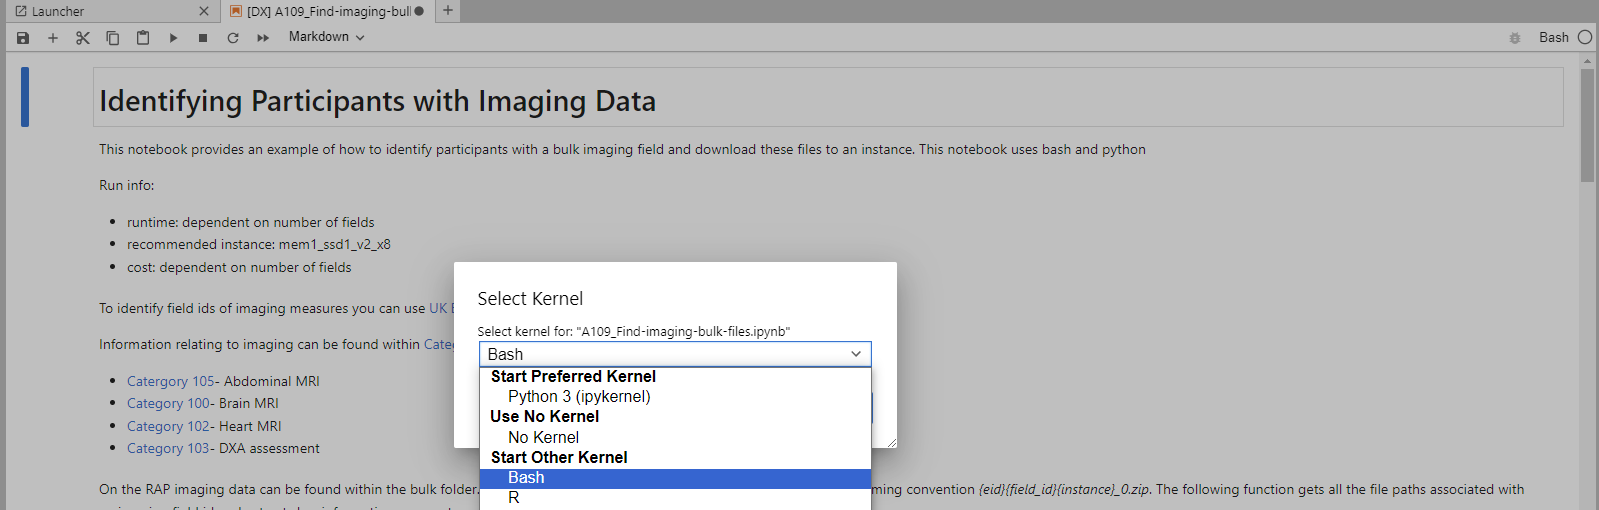

In [ ]:
import os
import pandas as pd
import dxpy
from collections import defaultdict
import json

In [ ]:
# Read txt file into pandas
data = pd.read_csv("imaging_eids.csv",index_col=None)


e.g. Sort data by a variable

In [ ]:
# Sort data frame by eid, then field_id
data_sorted_eid = data.sort_values(by=['eid','field_id'])

# Sort data frame by field id, then eid
data_sorted_image = data.sort_values(by=['field_id','eid'])

e.g. Create a JSON file

In [ ]:
# Initialize a nested defaultdict structure.
organized_data = defaultdict(lambda: defaultdict(list))

# Iterate over each row in the eid_images list, seperate row into indvidual variables
# and append a dictionary 
for index, row in data.iterrows():
    filepath, param, eid, field_id, ins = row
    organized_data[eid]['field_id'].append({
        'filepath': filepath,
        'parameter': param,
        'field_id': field_id,
        'instance': ins
    })

# Convert defaultdict to a regular dict
organized_data = {k: dict(v) for k, v in organized_data.items()}

# Specify the file name for the JSON file.
file_name = "images_per_eid.json"

# Open a file for writing and save the JSON data.
with open(file_name, 'w') as json_file:
    json.dump(organized_data, json_file, indent=4)

print(f"Data successfully saved to {file_name}")

# Upload file to project
dxpy.upload_local_file('images_per_eid.json')